#Data Loading

In [ ]:
#prod
#!pip install imbalanced-learn
!pip install rfpimp

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_validate
from statistics import mean
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import rfpimp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for rfpimp: filename=rfpimp-1.3.7-py3-none-any.whl size=10669 sha256=aeec728b88528f6ce033bf6e93d87d684849eead60aeba750c842216237536e4
  Stored in directory: /root/.cache/pip/wheels/ad/48/d9/21fc62fbeff405425b0d5dd8b0354576cdb62ac97f6b11d1ef
Successfully built rfpimp


In [ ]:
#prod
#Data stored in Google Drive, must authenticate to pull data
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
#prod
#01_M02_DC_train
#https://drive.google.com/file/d/1DO8bKxsTZe8gQ_zNnf6X1-9xlsWw37y2/view?usp=sharing
fileDownloaded = drive.CreateFile({'id':'1DO8bKxsTZe8gQ_zNnf6X1-9xlsWw37y2'})
fileDownloaded.GetContentFile('01_M02_DC_train.csv')

#01_M02_train_fault_data
#https://drive.google.com/file/d/1dppx60e2tdu4nm2XvZ1lRlMVPnVI4cvV/view?usp=sharing
fileDownloaded = drive.CreateFile({'id':'1dppx60e2tdu4nm2XvZ1lRlMVPnVI4cvV'})
fileDownloaded.GetContentFile('01_M02_train_fault_data.csv')

#01_M02_DC_train_ttf
#https://drive.google.com/file/d/1xBhlyjDhO1t_jXJLsKxP-SXD0XhKtmAU/view?usp=sharing
fileDownloaded = drive.CreateFile({'id':'1xBhlyjDhO1t_jXJLsKxP-SXD0XhKtmAU'})
fileDownloaded.GetContentFile('01_M02_DC_train_ttf.csv')

#loading into CSVs
df_train = pd.read_csv('01_M02_DC_train.csv', delimiter=',')
df_train.set_index('time')

df_fault = pd.read_csv('01_M02_train_fault_data.csv', delimiter=',')
df_fault.set_index('time')

df_ttf = pd.read_csv('01_M02_DC_train_ttf.csv', delimiter=',')
df_ttf.set_index('time')


# #03_M02_DC_train
# #https://drive.google.com/file/d/1Mho3WwCHX5JUo5IZwibV5MNBvJr_ZRhJ/view?usp=share_link
# fileDownloaded = drive.CreateFile({'id':'1Mho3WwCHX5JUo5IZwibV5MNBvJr_ZRhJ'})
# fileDownloaded.GetContentFile('03_M02_DC_train.csv')

# #03_M02_train_fault_data
# #https://drive.google.com/file/d/1-uZaGxkZBF-wrg5mBIL1WIL187Bc_cUt/view?usp=sharing
# fileDownloaded = drive.CreateFile({'id':'1-uZaGxkZBF-wrg5mBIL1WIL187Bc_cUt'})
# fileDownloaded.GetContentFile('03_M02_train_fault_data.csv')

# #03_M02_DC_train_ttf
# #https://drive.google.com/file/d/1IpBcjBap0LCVqKLb2Uwk3biTuXlpB4qF/view?usp=sharing
# fileDownloaded = drive.CreateFile({'id':'1IpBcjBap0LCVqKLb2Uwk3biTuXlpB4qF'})
# fileDownloaded.GetContentFile('03_M02_DC_train_ttf.csv')

# #loading into CSVs
# df_train = pd.read_csv('03_M02_DC_train.csv', delimiter=',')
# df_train.set_index('time')

# df_fault = pd.read_csv('03_M02_train_fault_data.csv', delimiter=',')
# df_fault.set_index('time')

# df_ttf = pd.read_csv('03_M02_DC_train_ttf.csv', delimiter=',')
# df_ttf.set_index('time')

# Proprocessing

In [ ]:
#prod
#Make sure the TTFs are all divisible by 4, and subtract mod 4 if not
df_ttf['TTF_FlowCool Pressure Dropped Below Limit'] = df_ttf['TTF_FlowCool Pressure Dropped Below Limit'].sub(df_ttf['TTF_FlowCool Pressure Dropped Below Limit'] % 4)
df_ttf['TTF_Flowcool Pressure Too High Check Flowcool Pump'] = df_ttf['TTF_Flowcool Pressure Too High Check Flowcool Pump'].sub(df_ttf['TTF_Flowcool Pressure Too High Check Flowcool Pump'] % 4)
df_ttf['TTF_Flowcool leak'] = df_ttf['TTF_Flowcool leak'].sub(df_ttf['TTF_Flowcool leak'] % 4)

#set failure time to mod 4 as well so the time index matches other datasets
df_fault['time'] = df_fault['time'].sub(df_fault['time'] % 4)

# #sanity check
# print(df_ttf.loc[df_ttf['TTF_FlowCool Pressure Dropped Below Limit'].isin([1, 2, 3])])
# print(df_ttf.loc[df_ttf['TTF_Flowcool Pressure Too High Check Flowcool Pump'].isin([1, 2, 3])])
# print(df_ttf.loc[df_ttf['TTF_Flowcool leak'].isin([1, 2, 3])])

#join the ttf and training data together on time
df = pd.concat([df_train, df_ttf], axis=1, join = 'inner')
df.columns = ['time', 'Tool', 'stage', 'Lot', 'runnum', 'recipe', 'recipe_step','IONGAUGEPRESSURE', 'ETCHBEAMVOLTAGE', 'ETCHBEAMCURRENT','ETCHSUPPRESSORVOLTAGE', 'ETCHSUPPRESSORCURRENT', 'FLOWCOOLFLOWRATE','FLOWCOOLPRESSURE', 'ETCHGASCHANNEL1READBACK', 'ETCHPBNGASREADBACK','FIXTURETILTANGLE', 'ROTATIONSPEED', 'ACTUALROTATIONANGLE','FIXTURESHUTTERPOSITION', 'ETCHSOURCEUSAGE', 'ETCHAUXSOURCETIMER','ETCHAUX2SOURCETIMER', 'ACTUALSTEPDURATION', 'time_drop','TTF_FlowCool Pressure Dropped Below Limit','TTF_Flowcool Pressure Too High Check Flowcool Pump','TTF_Flowcool leak']
#drop excess "time" column by position
df = df.drop(df.columns[24],axis = 1)

#FSP of 1 is the only important data
df = df.loc[df['FIXTURESHUTTERPOSITION'] == 1]
#drop NaNs that are present at the end of ttf (no more failures)
df = df.dropna(subset=['TTF_FlowCool Pressure Dropped Below Limit','TTF_Flowcool Pressure Too High Check Flowcool Pump', 'TTF_Flowcool leak'], how='all')
#drop duplicates ignoring the time and TTF columns
df.drop_duplicates(subset=df.columns.difference(['time', 'TTF_FlowCool Pressure Dropped Below Limit', 'TTF_Flowcool Pressure Too High Check Flowcool Pump',	'TTF_Flowcool leak']))

#Make 3 dataframes, one for each fail type
df_f1 = df.drop(['TTF_Flowcool Pressure Too High Check Flowcool Pump', 'TTF_Flowcool leak', "time", "Tool", "ROTATIONSPEED", "FIXTURESHUTTERPOSITION"],axis = 1)
df_f1 = df_f1.dropna()
df_f2 = df.drop(['TTF_FlowCool Pressure Dropped Below Limit',          'TTF_Flowcool leak', "time", "Tool", "ROTATIONSPEED", "FIXTURESHUTTERPOSITION"],axis = 1)
df_f2 = df_f2.dropna()
df_f3 = df.drop(['TTF_FlowCool Pressure Dropped Below Limit', 'TTF_Flowcool Pressure Too High Check Flowcool Pump', "time", "Tool", "ROTATIONSPEED", "FIXTURESHUTTERPOSITION"],axis = 1)
df_f3 = df_f3.dropna()

#stage, recipe, and recipe step are categorical and need to be encoded as such, but adds complexity. Wu dropped them. include OHE in Proprocess_data function

In [ ]:
#prod
def PreProcess_Data(df_f1, df_f2, df_f3, numKept, numFail):
    #only keep the data within 6000 seconds of a failure  to closer analyze the data
    df_f1 = df_f1.loc[df['TTF_FlowCool Pressure Dropped Below Limit'] < numKept]
    df_f2 = df_f2.loc[df['TTF_Flowcool Pressure Too High Check Flowcool Pump'] < numKept]
    df_f3 = df_f3.loc[df['TTF_Flowcool leak'] < numKept]

    # df_f1['IsFailure'] = np.where(df_f1['TTF_FlowCool Pressure Dropped Below Limit'] < numFail, True, False)
    # df_f2['IsFailure'] = np.where(df_f2['TTF_Flowcool Pressure Too High Check Flowcool Pump'] < numFail, True, False)
    # df_f3['IsFailure'] = np.where(df_f3['TTF_Flowcool leak'] < numFail, True, False)
    df_f1.loc[df_f1['TTF_FlowCool Pressure Dropped Below Limit'] < numFail, 'IsFailure'] = 1
    df_f1.loc[df_f1['TTF_FlowCool Pressure Dropped Below Limit'] >= numFail, 'IsFailure'] = 0

    df_f2.loc[df_f2['TTF_Flowcool Pressure Too High Check Flowcool Pump'] < numFail, 'IsFailure'] = 0
    df_f2.loc[df_f2['TTF_Flowcool Pressure Too High Check Flowcool Pump'] > numFail, 'IsFailure'] = 1

    df_f3.loc[df_f3['TTF_Flowcool leak'] < numFail, 'IsFailure'] = 0
    df_f3.loc[df_f3['TTF_Flowcool leak'] > numFail, 'IsFailure'] = 1

    return df_f1, df_f2, df_f3

# RFC Pickle

In [ ]:
#prod
#get data with 5000 points from 0 as relevant and 250 point from 0 being fail data
df1, df2, df3 = PreProcess_Data(df_f1, df_f2, df_f3, 5000, 250)

#drop categorical columns
df_temp = df1[['TTF_FlowCool Pressure Dropped Below Limit', 'IsFailure']]
df1 = df1.drop(['stage', 'recipe', 'recipe_step', 'TTF_FlowCool Pressure Dropped Below Limit', 'IsFailure'], axis=1)

#implement a standard scaler to normalize the dataset, but not scaling the target values.
scaler = StandardScaler()
scaler.fit(df1)
df1_scaled = scaler.transform(df1)
df1_scaled = pd.DataFrame(df1_scaled, columns = df1.columns)
#reintroduce the target values
df_index = pd.DataFrame(df_temp.index.values)
df1_scaled = pd.concat([df1_scaled, df_index], axis=1, join = 'inner')
df1_scaled = df1_scaled.set_index(0)
df1_scaled = pd.concat([df1_scaled, df_temp ], axis=1, join = 'inner')

#get indices where TTF is 0 from df1
zero_index = df1_scaled.index[df1_scaled['TTF_FlowCool Pressure Dropped Below Limit'] == 0].tolist()
#get data from the third to last 0, until the second to last 0. This will be the test data
df_stream = df1_scaled.loc[zero_index[-3] : zero_index[-2]]

#train data is all data until the third to last 0
df_stream_train = df1_scaled.loc[:zero_index[-3]]

df_stream_xTrain = df_stream_train.drop(['TTF_FlowCool Pressure Dropped Below Limit', 'IsFailure'], axis=1)
df_stream_yTrain = df_stream_train['IsFailure']
#Use SMOTE to oversample the minority class
oversample = SMOTE()
df_stream_xTrain_smote, df_stream_yTrain_smote = oversample.fit_resample(df_stream_xTrain, df_stream_yTrain)

#test data is from the last uninterupted count to 0 in the dataset
df_stream_test = df_stream.loc[df_stream[df_stream['TTF_FlowCool Pressure Dropped Below Limit'] > df_stream['TTF_FlowCool Pressure Dropped Below Limit'].shift().rolling(2, min_periods=1).min()].tail(1).index.item():]

df_stream_xTest = df_stream_test.drop(['TTF_FlowCool Pressure Dropped Below Limit', 'IsFailure'], axis=1)
df_stream_yTest = df_stream_test['IsFailure']

RANDOM FOREST RESULTS: 

              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97       991
         1.0       0.50      1.00      0.66        63

    accuracy                           0.94      1054
   macro avg       0.75      0.97      0.81      1054
weighted avg       0.97      0.94      0.95      1054



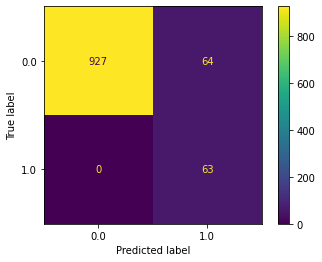

In [ ]:
#LOADED MODEL FROM PICKLE
import pickle
filename = 'Data_606_RFC.sav'

#https://drive.google.com/file/d/1E98XDFCSWyiSZntCud0BEyBSTCtDUtKV/view?usp=share_link
fileDownloaded = drive.CreateFile({'id':'1E98XDFCSWyiSZntCud0BEyBSTCtDUtKV'})
fileDownloaded.GetContentFile(filename)

RFC = pickle.load(open(filename, 'rb'))

print("RANDOM FOREST RESULTS: \n")        
y_pred_stream = RFC.predict(df_stream_xTest)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(df_stream_yTest, y_pred_stream),
                               display_labels=RFC.classes_)
disp.plot()
print(classification_report(df_stream_yTest, y_pred_stream))

In [ ]:
#next, regression
RFR = RandomForestRegressor(n_estimators=100, n_jobs=-1)
RFR.fit(df_stream_xTrain, df_stream_train['TTF_FlowCool Pressure Dropped Below Limit'])
y_prediction = RFR.predict(df_stream_xTest)

score=r2_score(df_stream_test['TTF_FlowCool Pressure Dropped Below Limit'],y_prediction)
print('r2 score is:',score)
print('mean_sqrd_error is:',mean_squared_error(df_stream_yTest,y_prediction))
print('root_mean_squared error of is:',np.sqrt(mean_squared_error(df_stream_yTest,y_prediction)))

r2 score is: -1.5619042115351927
mean_sqrd_error is: 3495836.4766072105
root_mean_squared error of is: 1869.7156138320101


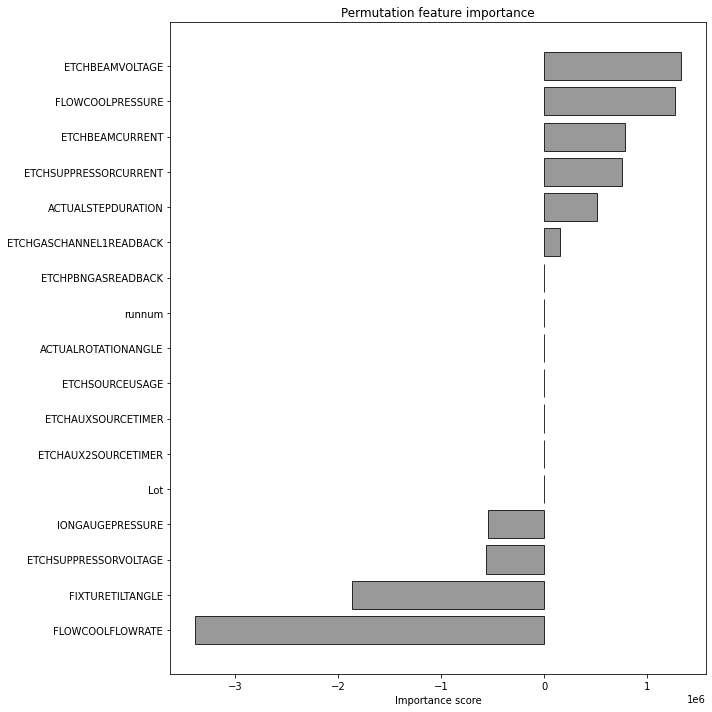

In [ ]:
imp = rfpimp.importances(RFR, df_stream_xTest, df_stream_yTest)

fig, ax = plt.subplots(figsize=(6, 3))

ax.barh(imp.index, imp['Importance'], height=0.8, facecolor='grey', alpha=0.8, edgecolor='k') #find how to only see top 10 bars
ax.set_xlabel('Importance score')
ax.set_title('Permutation feature importance')
plt.gca().invert_yaxis()
fig.set_size_inches(10, 10)

fig.tight_layout()

In [ ]:
#loop through the test data, inserting 1 row at a time
for i in range(len(df_stream_xTest)):
    #if the RFC predicts a fail with over 55% confidence
    predictions = RFC.predict_proba(df_stream_xTest.iloc[[i]])
    if predictions[0][1] > 0.55:
        #output the estimate of the regressor
        print("The regressor estimated a TTF of:" + str(RFR.predict(df_stream_xTest.iloc[[i]])[0]))
        #versus the true TTF
        print(df_stream_test.iloc[[i]])
        #and the prediction that the RFC made
        print(predictions[0][1])
        print('--------------------------------------------------------')

The regressor estimated a TTF of:2232.12
             Lot    runnum  IONGAUGEPRESSURE  ETCHBEAMVOLTAGE  \
3000472 -0.14556  0.295618         -0.032993         0.974211   

         ETCHBEAMCURRENT  ETCHSUPPRESSORVOLTAGE  ETCHSUPPRESSORCURRENT  \
3000472         0.495865               0.890604               0.095097   

         FLOWCOOLFLOWRATE  FLOWCOOLPRESSURE  ETCHGASCHANNEL1READBACK  \
3000472          0.902661          0.068823                -0.606006   

         ETCHPBNGASREADBACK  FIXTURETILTANGLE  ACTUALROTATIONANGLE  \
3000472           -0.596428          0.260321            -0.451982   

         ETCHSOURCEUSAGE  ETCHAUXSOURCETIMER  ETCHAUX2SOURCETIMER  \
3000472        -0.569799           -0.533308            -0.533308   

         ACTUALSTEPDURATION  TTF_FlowCool Pressure Dropped Below Limit  \
3000472            1.189286                                      480.0   

         IsFailure  
3000472        0.0  
0.5784333117920063
--------------------------------------------

# RFC New

In [ ]:
#prod
#get data with 5000 points from 0 as relevant and 250 point from 0 being fail data
df1, df2, df3 = PreProcess_Data(df_f1, df_f2, df_f3, 5000, 250)

#drop categorical columns and highly coorelated columns
df_temp = df1[['TTF_FlowCool Pressure Dropped Below Limit', 'IsFailure']]
df1 = df1.drop(['stage', 'recipe', 'recipe_step',  'Lot', 'runnum', 'ETCHBEAMCURRENT','ETCHSUPPRESSORVOLTAGE', 'ETCHSUPPRESSORCURRENT', 'ETCHAUXSOURCETIMER','ETCHAUX2SOURCETIMER', 'TTF_FlowCool Pressure Dropped Below Limit', 'IsFailure'], axis=1)

#implement a standard scaler to normalize the dataset, but not scaling the target values.
scaler = StandardScaler()
scaler.fit(df1)
df1_scaled = scaler.transform(df1)
df1_scaled = pd.DataFrame(df1_scaled, columns = df1.columns)
#reintroduce the target values
df_index = pd.DataFrame(df_temp.index.values)
df1_scaled = pd.concat([df1_scaled, df_index], axis=1, join = 'inner')
df1_scaled = df1_scaled.set_index(0)
df1_scaled = pd.concat([df1_scaled, df_temp ], axis=1, join = 'inner')

#get indices where TTF is 0 from df1
zero_index = df1_scaled.index[df1_scaled['TTF_FlowCool Pressure Dropped Below Limit'] == 0].tolist()
#get data from the third to last 0, until the second to last 0. This will be the test data
df_stream = df1_scaled.loc[zero_index[-3] : zero_index[-2]]

#train data is all data until the third to last 0
df_stream_train = df1_scaled.loc[:zero_index[-3]]

df_stream_xTrain = df_stream_train.drop(['TTF_FlowCool Pressure Dropped Below Limit', 'IsFailure'], axis=1)
df_stream_yTrain = df_stream_train['IsFailure']
#Use SMOTE to oversample the minority class
oversample = SMOTE()
df_stream_xTrain_smote, df_stream_yTrain_smote = oversample.fit_resample(df_stream_xTrain, df_stream_yTrain)

#test data is from the last uninterupted count to 0 in the dataset
df_stream_test = df_stream.loc[df_stream[df_stream['TTF_FlowCool Pressure Dropped Below Limit'] > df_stream['TTF_FlowCool Pressure Dropped Below Limit'].shift().rolling(2, min_periods=1).min()].tail(1).index.item():]

df_stream_xTest = df_stream_test.drop(['TTF_FlowCool Pressure Dropped Below Limit', 'IsFailure'], axis=1)
df_stream_yTest = df_stream_test['IsFailure']

RANDOM FOREST RESULTS: 

              precision    recall  f1-score   support

         0.0       1.00      0.83      0.91       991
         1.0       0.27      1.00      0.43        63

    accuracy                           0.84      1054
   macro avg       0.64      0.92      0.67      1054
weighted avg       0.96      0.84      0.88      1054



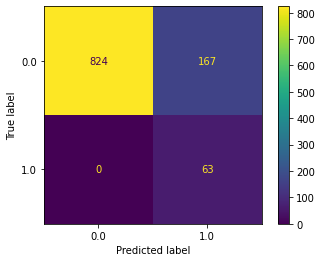

In [ ]:
#MAKING A NEW RFC
RFC = RandomForestClassifier(n_estimators=100, n_jobs = -1, criterion = 'entropy', max_depth = 5, random_state = 25)
#RFC.fit(df_stream_xTrain, df_stream_yTrain)
RFC.fit(df_stream_xTrain_smote, df_stream_yTrain_smote)

print("RANDOM FOREST RESULTS: \n")        
y_pred_stream = RFC.predict(df_stream_xTest)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(df_stream_yTest, y_pred_stream),
                               display_labels=RFC.classes_)
disp.plot()
print(classification_report(df_stream_yTest, y_pred_stream))

In [ ]:
#next, regression
RFR = RandomForestRegressor(n_estimators=100, n_jobs=-1)
RFR.fit(df_stream_xTrain, df_stream_train['TTF_FlowCool Pressure Dropped Below Limit'])
y_prediction = RFR.predict(df_stream_xTest)

score=r2_score(df_stream_test['TTF_FlowCool Pressure Dropped Below Limit'],y_prediction)
print('r2 score is:',score)
print('mean_sqrd_error is:',mean_squared_error(df_stream_yTest,y_prediction))
print('root_mean_squared error of is:',np.sqrt(mean_squared_error(df_stream_yTest,y_prediction)))

r2 score is: -0.35677272162882434
mean_sqrd_error is: 3798501.3739430737
root_mean_squared error of is: 1948.9744415828222


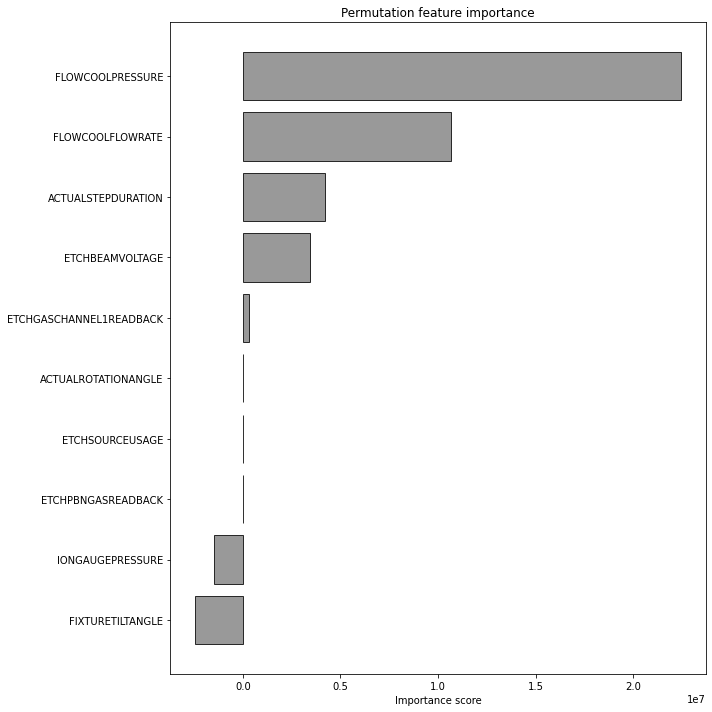

In [ ]:
imp = rfpimp.importances(RFR, df_stream_xTest, df_stream_yTest)

fig, ax = plt.subplots(figsize=(6, 3))

ax.barh(imp.index, imp['Importance'], height=0.8, facecolor='grey', alpha=0.8, edgecolor='k') #find how to only see top 10 bars
ax.set_xlabel('Importance score')
ax.set_title('Permutation feature importance')
plt.gca().invert_yaxis()
fig.set_size_inches(10, 10)

fig.tight_layout()

In [ ]:
#loop through the test data, inserting 1 row at a time
for i in range(len(df_stream_xTest)):
    #if the RFC predicts a fail with over 55% confidence
    predictions = RFC.predict_proba(df_stream_xTest.iloc[[i]])
    if predictions[0][1] > 0.55:
        #output the estimate of the regressor
        print("The regressor estimated a TTF of:" + str(RFR.predict(df_stream_xTest.iloc[[i]])[0]))
        #versus the true TTF
        print(df_stream_test.iloc[[i]])
        #and the prediction that the RFC made
        print(predictions[0][1])
        print('--------------------------------------------------------')

The regressor estimated a TTF of:1280.16
         IONGAUGEPRESSURE  ETCHBEAMVOLTAGE  FLOWCOOLFLOWRATE  \
2999537         -0.011829          0.70892         -1.080046   

         FLOWCOOLPRESSURE  ETCHGASCHANNEL1READBACK  ETCHPBNGASREADBACK  \
2999537         -1.326109                 1.075821            0.126243   

         FIXTURETILTANGLE  ACTUALROTATIONANGLE  ETCHSOURCEUSAGE  \
2999537         -0.655985            -0.451982        -0.572383   

         ACTUALSTEPDURATION  TTF_FlowCool Pressure Dropped Below Limit  \
2999537           -0.967073                                     4220.0   

         IsFailure  
2999537        0.0  
0.5513875788395397
--------------------------------------------------------
The regressor estimated a TTF of:1277.32
         IONGAUGEPRESSURE  ETCHBEAMVOLTAGE  FLOWCOOLFLOWRATE  \
2999538         -0.011829         0.708667         -0.997892   

         FLOWCOOLPRESSURE  ETCHGASCHANNEL1READBACK  ETCHPBNGASREADBACK  \
2999538         -1.333277          